In [80]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler

from sklearn.utils import resample
import pickle

In [81]:
fire = pd.read_csv("../data/forestfires.csv")

In [82]:
fire.drop(columns=["X","Y","month","day"],inplace=True)

In [83]:
fire['fire'] = fire['area'].apply(lambda x: 1 if x > 0 else 0)
fire = fire.drop(columns =["area"])

In [84]:
print(fire.skew(numeric_only=True))

FFMC    -6.575606
DMC      0.547498
DC      -1.100445
ISI      2.536325
temp    -0.331172
RH       0.862904
wind     0.571001
rain    19.816344
fire    -0.089322
dtype: float64


In [85]:
#Get rid of the skewness
fire['ISI_log'] = np.log1p(fire['ISI'])
fire['rain_log'] = np.log1p(fire['rain'])

fire['FFMC_reversed'] = fire['FFMC'].max() + 1 - fire['FFMC']
fire['FFMC_log'] = np.log1p(fire['FFMC_reversed'])

In [86]:
fire_unskew = fire.drop(columns=["ISI","rain","FFMC","FFMC_reversed"])

In [87]:
fire = fire.drop(columns=["ISI_log","FFMC_log","FFMC_reversed"])

In [88]:
print(fire_unskew.skew(numeric_only=True))

DMC          0.547498
DC          -1.100445
temp        -0.331172
RH           0.862904
wind         0.571001
fire        -0.089322
ISI_log     -0.937218
rain_log    14.173028
FFMC_log     0.715814
dtype: float64


In [89]:
print(fire.skew(numeric_only=True))

FFMC        -6.575606
DMC          0.547498
DC          -1.100445
ISI          2.536325
temp        -0.331172
RH           0.862904
wind         0.571001
rain        19.816344
fire        -0.089322
rain_log    14.173028
dtype: float64


In [90]:
#remove outliers in rain
fire_clean = fire_unskew

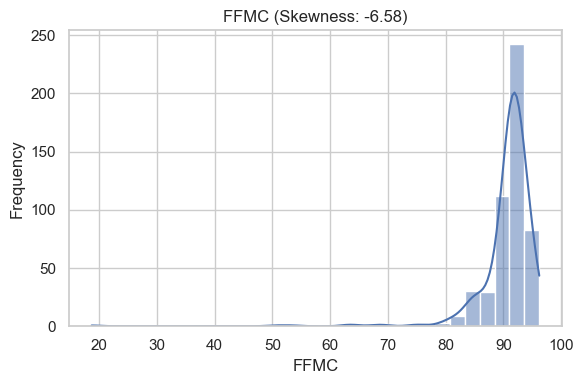

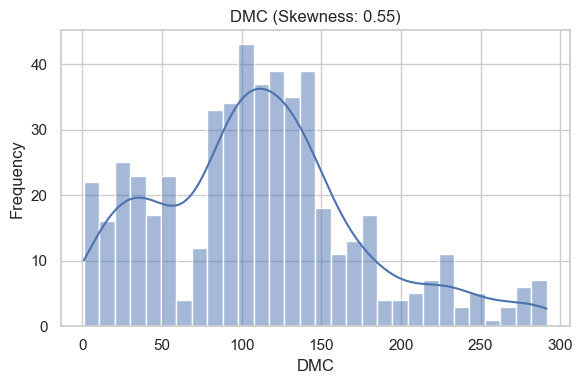

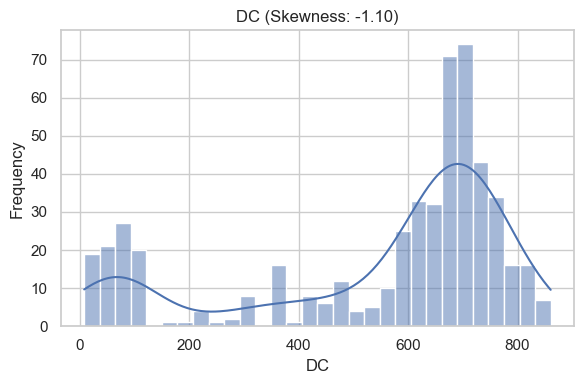

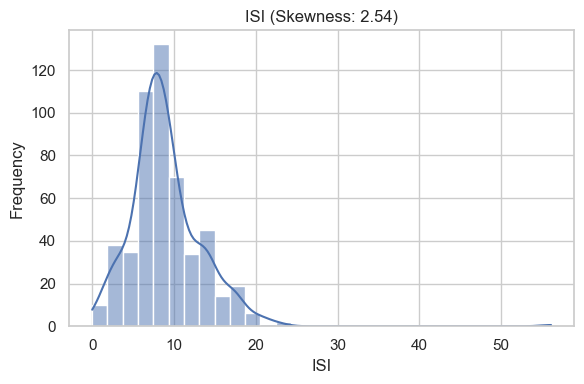

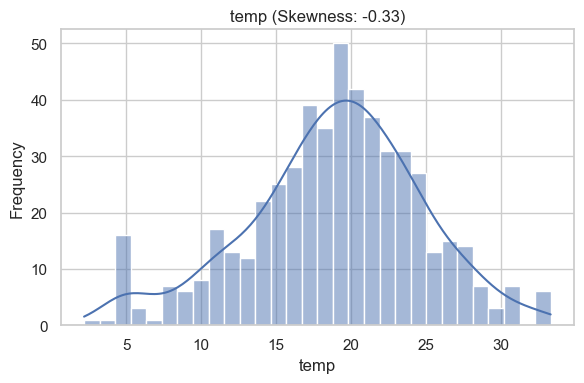

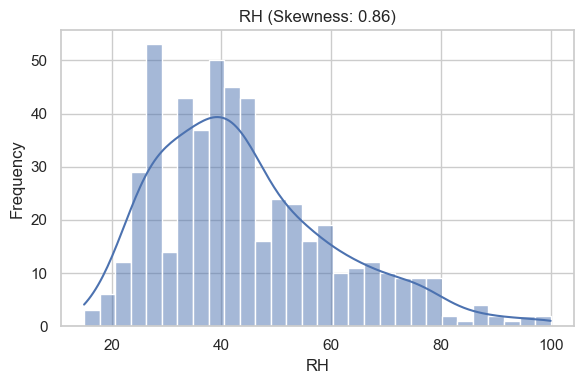

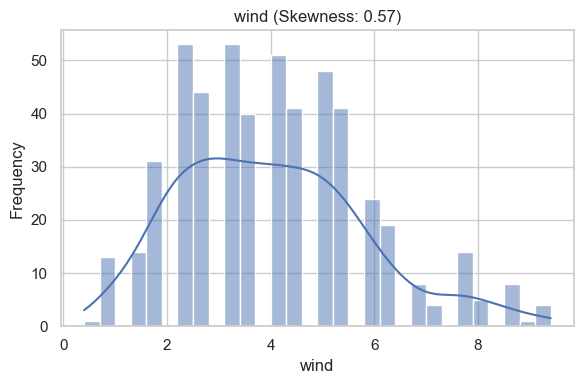

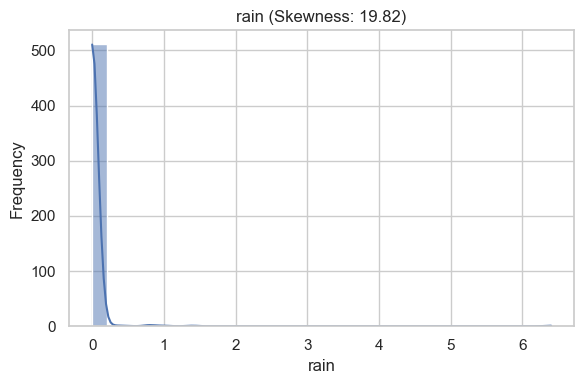

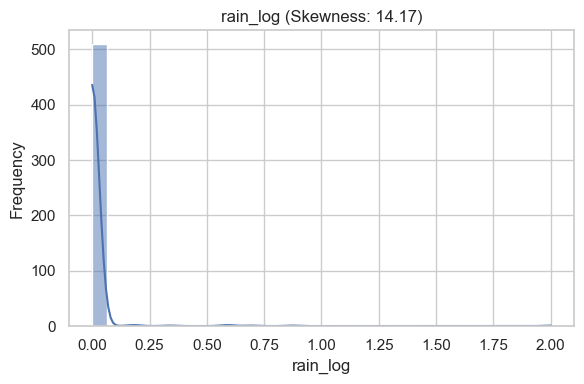

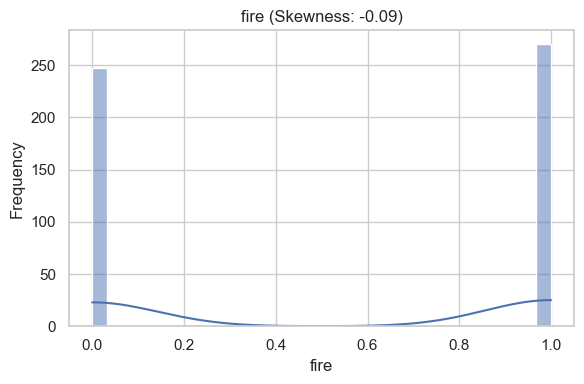

In [22]:
import seaborn as sns
numerical_cols = fire.select_dtypes(include=['int64', 'float64']).columns

# Set the plot style
sns.set(style="whitegrid")

# Plot each feature
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(fire[col], kde=True, bins=30)
    skewness = fire[col].skew()
    plt.title(f'{col} (Skewness: {skewness:.2f})')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

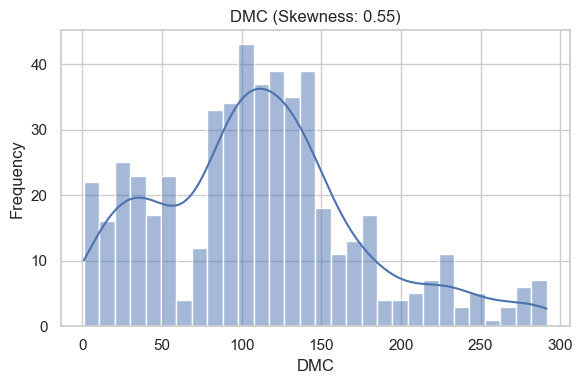

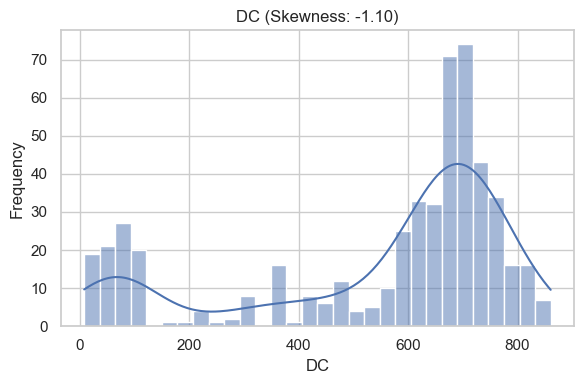

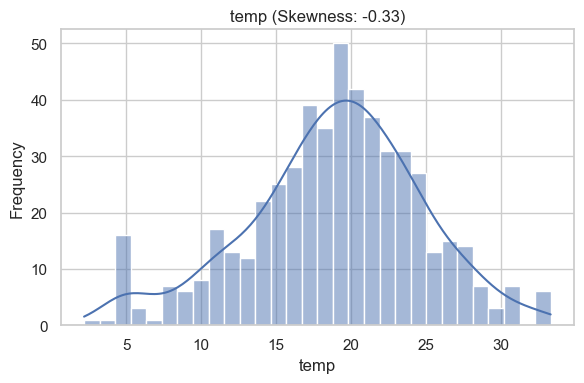

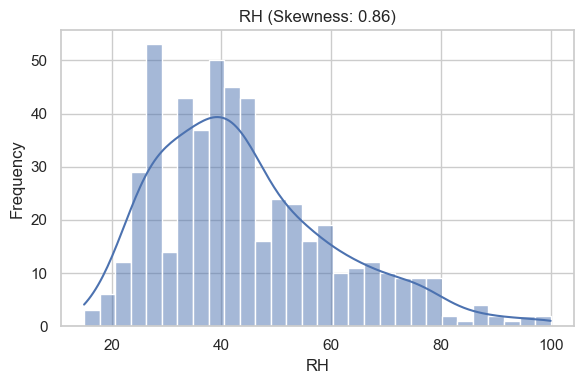

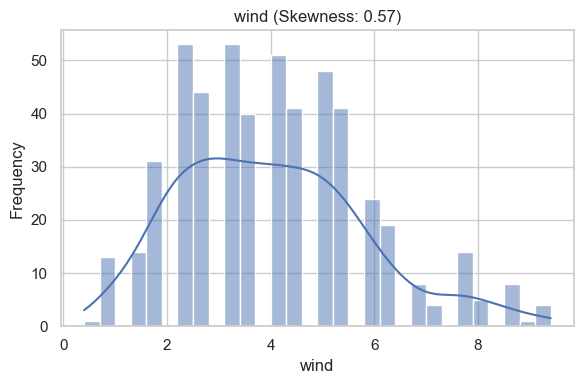

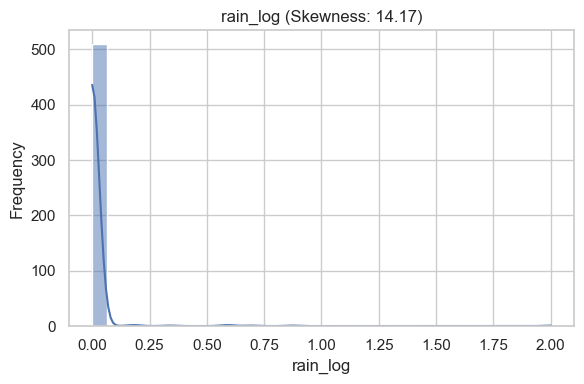

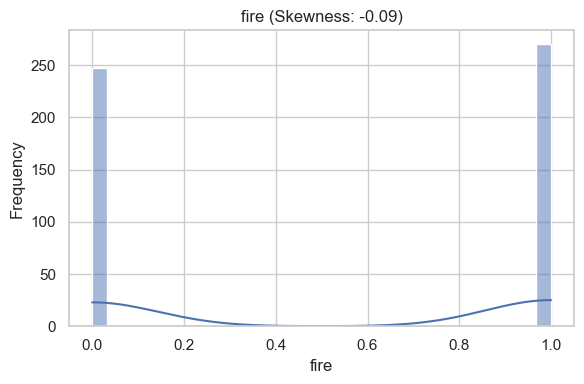

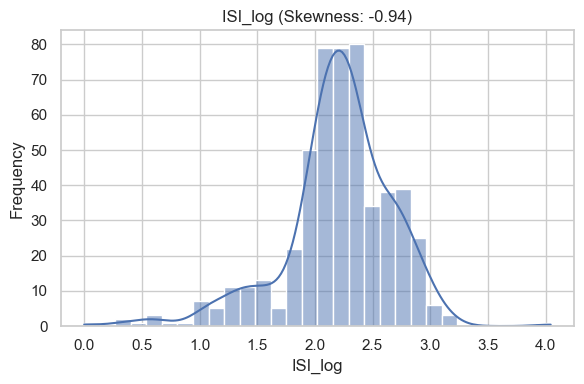

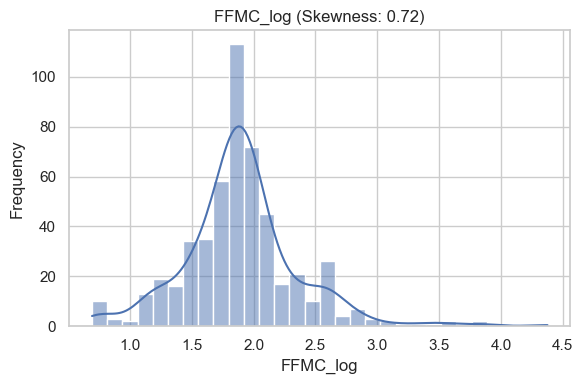

In [23]:
numerical_cols = fire_unskew.select_dtypes(include=['int64', 'float64']).columns

# Set the plot style
sns.set(style="whitegrid")

# Plot each feature
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(fire_unskew[col], kde=True, bins=30)
    skewness = fire_unskew[col].skew()
    plt.title(f'{col} (Skewness: {skewness:.2f})')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [91]:
test = fire_clean
features = test.drop(columns=["fire"])
target = test["fire"]

In [92]:
test.head()

,DMC,DC,temp,RH,wind,fire,ISI_log,rain_log,FFMC_log
0,26.2,94.3,8.2,51,6.7,0,1.808289,0.000000,2.484907
1,35.4,669.1,18.0,33,0.9,0,2.041220,0.000000,2.028148
2,43.7,686.9,14.6,33,1.3,0,2.041220,0.000000,2.028148
3,33.3,77.5,8.3,97,4.0,0,2.302585,0.182322,1.871802
4,51.3,102.2,11.4,99,1.8,0,2.360854,0.000000,2.186051


In [93]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0)

In [94]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
normalizer = MinMaxScaler()
normalizer.fit(X_train)
X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)
X_train_norm = pd.DataFrame(X_train_norm, columns=X_train.columns, index=X_train.index)
X_test_norm = pd.DataFrame(X_test_norm, columns=X_test.columns, index=X_test.index)

In [32]:
with open("../models/Normalizer/normalizer.pk1", "wb") as file:
    pickle.dump(normalizer, file)

In [96]:
fire.shape

(517, 10)

In [97]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, f1_score
knn = KNeighborsClassifier(n_neighbors=13) 
knn.fit(X_train_norm, y_train)
y_pred = knn.predict(X_test_norm)
print(f"The accuracy of the model is {knn.score(X_test_norm, y_test) *100: .2f}%")
print(f"The Recall for True fires is {recall_score(y_test, y_pred,average = "binary") *100: .2f}%")
print(f"The F1 is {f1_score(y_test, y_pred,average = "binary") *100: .2f}%")
print(f"The Precision is {precision_score(y_test, y_pred,average = "binary") *100: .2f}%")

The accuracy of the model is  51.92%
The Recall for True fires is  51.67%
The F1 is  55.36%
The Precision is  59.62%


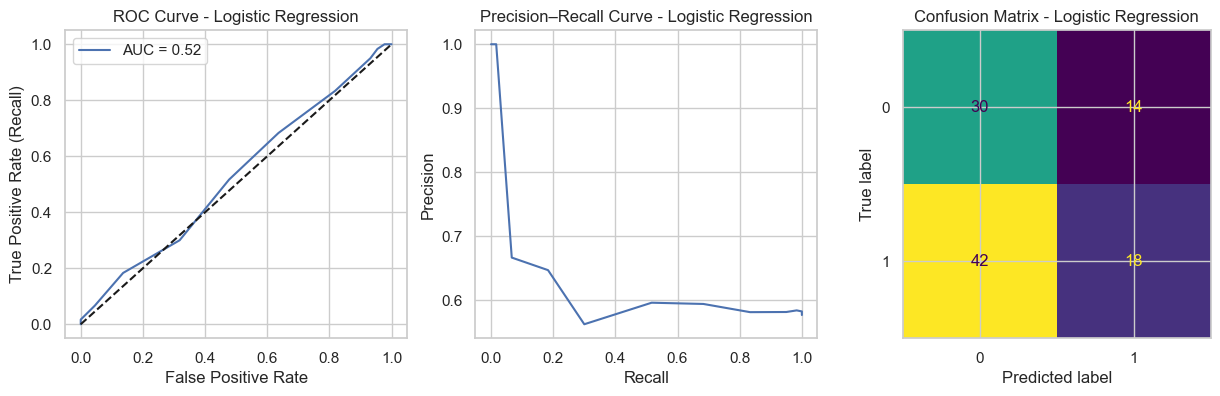

In [128]:
y_proba = knn.predict_proba(X_test_norm)[:, 1]
y_pred = (y_proba >= 0.55).astype(int)

fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(15, 4))

    # ROC
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title(f'ROC Curve - Logistic Regression')
plt.legend()

    # --- Precision–Recall Curve ---
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.subplot(1, 3, 2)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision–Recall Curve - Logistic Regression')

    # --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.subplot(1, 3, 3)
ConfusionMatrixDisplay(cm).plot(ax=plt.gca(), colorbar=False)
plt.title(f'Confusion Matrix - Logistic Regression')
plt.show()

In [125]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=100,random_state=0)
logreg.fit(X_train_norm,y_train)
y_pred = logreg.predict(X_test_norm)
print(f"The accuracy of the model is {logreg.score(X_test_norm, y_test) *100: .2f}%")
print(f"The Recall for True fires is {recall_score(y_test, y_pred,average = "binary") *100: .2f}%")
print(f"The F1 is {f1_score(y_test, y_pred,average = "binary") *100: .2f}%")
print(f"The Precision is {precision_score(y_test, y_pred,average = "binary") *100: .2f}%")

The accuracy of the model is  62.50%
The Recall for True fires is  80.00%
The F1 is  71.11%
The Precision is  64.00%


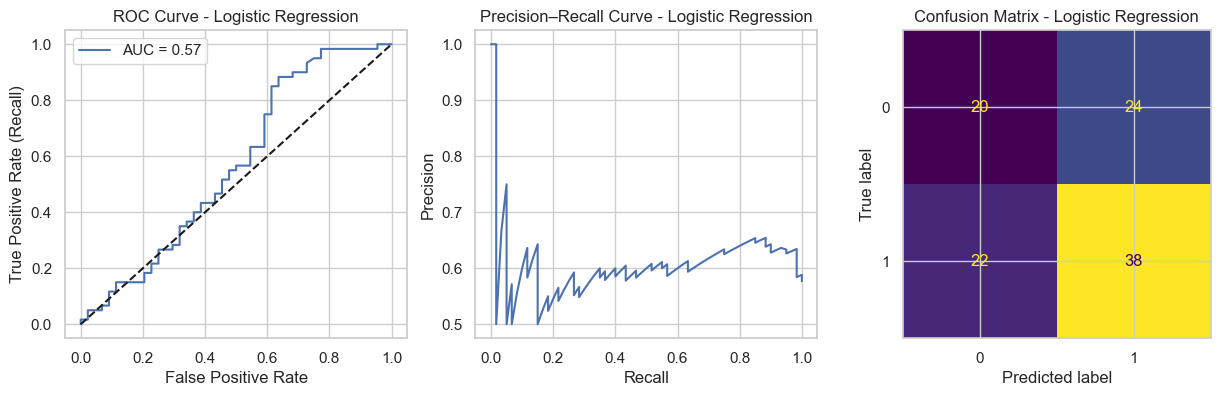

In [126]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score,precision_recall_curve,confusion_matrix, ConfusionMatrixDisplay

y_proba = logreg.predict_proba(X_test_norm)[:, 1]
y_pred = (y_proba >= 0.55
         ).astype(int)

fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(15, 4))

    # ROC
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title(f'ROC Curve - Logistic Regression')
plt.legend()

    # --- Precision–Recall Curve ---
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.subplot(1, 3, 2)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision–Recall Curve - Logistic Regression')

    # --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.subplot(1, 3, 3)
ConfusionMatrixDisplay(cm).plot(ax=plt.gca(), colorbar=False)
plt.title(f'Confusion Matrix - Logistic Regression')
plt.show()

In [38]:
with open("../models/Logistic_reg/logreg.pk1", "wb") as file:
    pickle.dump(logreg, file)

In [122]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier (max_depth = 10, random_state = 0)
tree.fit(X_train_norm, y_train)
y_pred = tree.predict(X_test_norm)
print(f"The accuracy of the model is {tree.score(X_test_norm, y_test) *100: .2f}%")
print(f"The Recall for True fires is {recall_score(y_test, y_pred,average = "binary") *100: .2f}%")
print(f"The F1 is {f1_score(y_test, y_pred,average = "binary") *100: .2f}%")
print(f"The Precision is {precision_score(y_test, y_pred,average = "binary") *100: .2f}%")

The accuracy of the model is  56.73%
The Recall for True fires is  58.33%
The F1 is  60.87%
The Precision is  63.64%


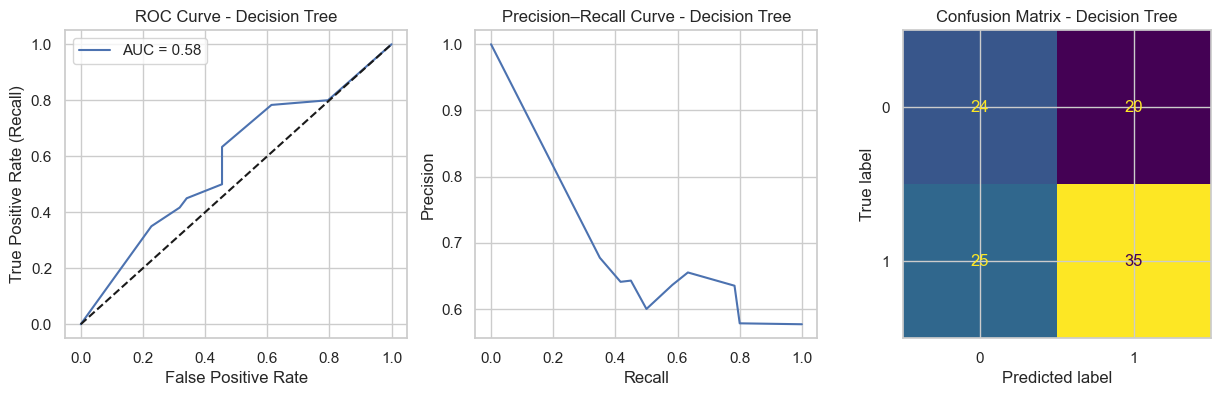

In [129]:
y_proba = tree.predict_proba(X_test_norm)[:, 1]
y_pred = (y_proba >= 0.52).astype(int)

fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(15, 4))

    # ROC
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title(f'ROC Curve - Decision Tree')
plt.legend()

    # --- Precision–Recall Curve ---
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.subplot(1, 3, 2)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision–Recall Curve - Decision Tree')

    # --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.subplot(1, 3, 3)
ConfusionMatrixDisplay(cm).plot(ax=plt.gca(), colorbar=False)
plt.title(f'Confusion Matrix - Decision Tree')
plt.show()

In [40]:
tree_importance = {feature : importance for feature, importance in zip(X_train_norm.columns, tree.feature_importances_)}
tree_importance

{'DMC': np.float64(0.11346843655661569),
 'DC': np.float64(0.1275568432533089),
 'temp': np.float64(0.252853141622486),
 'RH': np.float64(0.1914781757074249),
 'wind': np.float64(0.1387491732640508),
 'rain_log': np.float64(0.0),
 'ISI_log': np.float64(0.07664745563214302),
 'FFMC_log': np.float64(0.09924677396397061)}

In [114]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
bagging_reg = BaggingClassifier(LogisticRegression(max_iter=100),
                               n_estimators=100, # number of models to use
                               max_samples = 100,random_state = 0)
bagging_reg.fit(X_train_norm, y_train)
y_pred_test_bag = bagging_reg.predict(X_test_norm)
print(f"The accuracy of the model is {bagging_reg.score(X_test_norm, y_test) *100: .2f}%")
print(f"The Recall for True fires is {recall_score(y_test, y_pred_test_bag,average = "binary") *100: .2f}%")
print(f"The F1 is {f1_score(y_test, y_pred_test_bag,average = "binary") *100: .2f}%")
print(f"The Precision is {precision_score(y_test, y_pred_test_bag,average = "binary") *100: .2f}%")

The accuracy of the model is  66.35%
The Recall for True fires is  91.67%
The F1 is  75.86%
The Precision is  64.71%


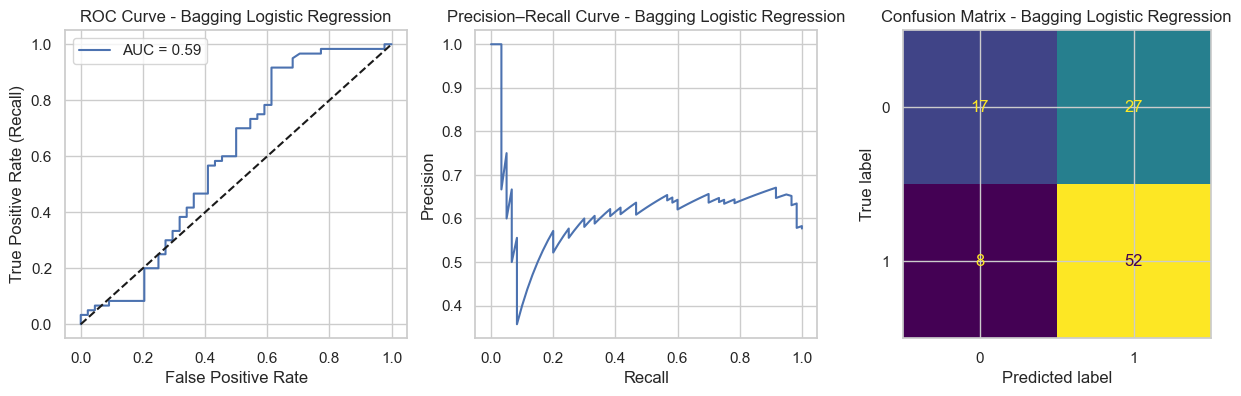

In [120]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score,precision_recall_curve,confusion_matrix, ConfusionMatrixDisplay

y_proba = bagging_reg.predict_proba(X_test_norm)[:, 1]
y_pred = (y_proba >= 0.51).astype(int)

fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(15, 4))

    # ROC
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title(f'ROC Curve - Bagging Logistic Regression')
plt.legend()

    # --- Precision–Recall Curve ---
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.subplot(1, 3, 2)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision–Recall Curve - Bagging Logistic Regression')

    # --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.subplot(1, 3, 3)
ConfusionMatrixDisplay(cm).plot(ax=plt.gca(), colorbar=False)
plt.title(f'Confusion Matrix - Bagging Logistic Regression')
plt.show()

In [54]:
with open("../models/Ensemble/bag_logreg.pk1", "wb") as file:
    pickle.dump(bagging_reg, file)

In [33]:
#AdaBoost Logistic regression
ada_reg = AdaBoostClassifier(LogisticRegression(max_iter=100),n_estimators=100, random_state=0)
ada_reg.fit(X_train_norm, y_train)
y_pred_test_ada = ada_reg.predict(X_test_norm)
print(f"The accuracy of the model is {ada_reg.score(X_test_norm, y_test) *100: .2f}%")
print(f"The Recall for True fires is {recall_score(y_test, y_pred_test_ada,average = "binary") *100: .2f}%")
print(f"The F1 is {f1_score(y_test, y_pred_test_ada,average = "binary") *100: .2f}%")
print(f"The Precision is {precision_score(y_test, y_pred_test_ada,average = "binary") *100: .2f}%")

The accuracy of the model is  58.65%
The Recall for True fires is  73.33%
The F1 is  67.18%
The Precision is  61.97%


In [42]:
#Gradient Boost
grad_reg = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
grad_reg.fit(X_train_norm, y_train)
y_pred_test_grad = grad_reg.predict(X_test_norm)
print(f"The accuracy of the model is {grad_reg.score(X_test_norm, y_test) *100: .2f}%")
print(f"The Recall for True fires is {recall_score(y_test, y_pred_test_grad,average = "binary") *100: .2f}%")
print(f"The F1 is {f1_score(y_test, y_pred_test_grad,average = "binary") *100: .2f}%")
print(f"The Precision is {precision_score(y_test, y_pred_test_grad,average = "binary") *100: .2f}%")

The accuracy of the model is  57.69%
The Recall for True fires is  66.67%
The F1 is  64.52%
The Precision is  62.50%


In [108]:
#AdaBoost Logistic regression + bagging
ada_bag_reg = AdaBoostClassifier(bagging_reg,n_estimators=100, random_state=0)
ada_bag_reg.fit(X_train_norm, y_train)
y_pred_test_ada_bag = ada_bag_reg.predict(X_test_norm)
print(f"The accuracy of the model is {ada_bag_reg.score(X_test_norm, y_test) *100: .2f}%")
print(f"The Recall for True fires is {recall_score(y_test, y_pred_test_ada_bag,average = "binary") *100: .2f}%")
print(f"The F1 is {f1_score(y_test, y_pred_test_ada_bag,average = "binary") *100: .2f}%")
print(f"The Precision is {precision_score(y_test, y_pred_test_ada_bag,average = "binary") *100: .2f}%")

The accuracy of the model is  57.69%
The Recall for True fires is  100.00%
The F1 is  73.17%
The Precision is  57.69%


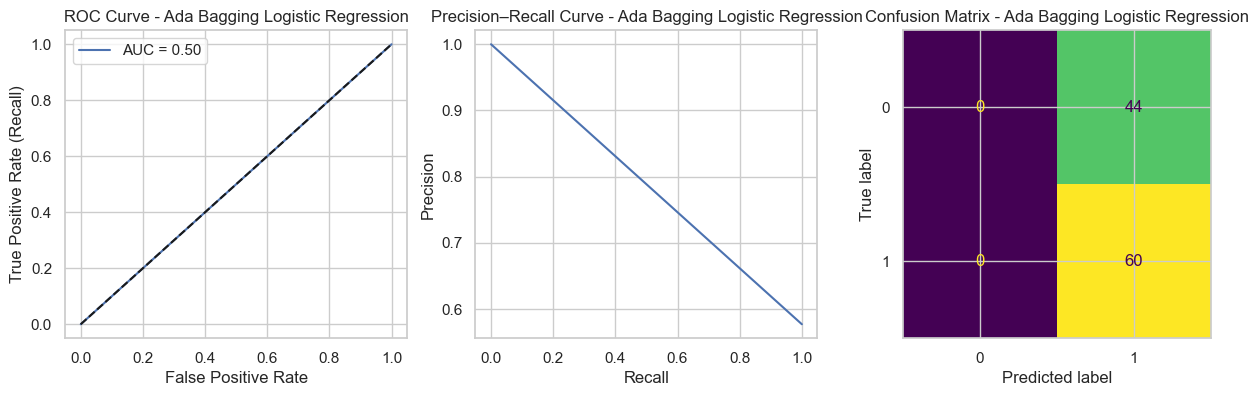

In [109]:
y_proba = ada_bag_reg.predict_proba(X_test_norm)[:, 1]
y_pred = (y_proba >= 0.7).astype(int)

fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(15, 4))

    # ROC
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title(f'ROC Curve - Ada Bagging Logistic Regression')
plt.legend()

    # --- Precision–Recall Curve ---
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.subplot(1, 3, 2)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision–Recall Curve - Ada Bagging Logistic Regression')

    # --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.subplot(1, 3, 3)
ConfusionMatrixDisplay(cm).plot(ax=plt.gca(), colorbar=False)
plt.title(f'Confusion Matrix - Ada Bagging Logistic Regression')
plt.show()

In [106]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=517, max_depth=50,random_state=0)
forest.fit(X_train_norm, y_train)
y_pred_test_rf = forest.predict(X_test_norm)

print(f"The accuracy of the model is {forest.score(X_test_norm, y_test) *100: .2f}%")
print(f"The Recall for True fires is {recall_score(y_test, y_pred_test_rf,average = "binary") *100: .2f}%")
print(f"The F1 is {f1_score(y_test, y_pred_test_rf,average = "binary") *100: .2f}%")
print(f"The Precision is {precision_score(y_test, y_pred_test_rf,average = "binary") *100: .2f}%")

The accuracy of the model is  56.73%
The Recall for True fires is  60.00%
The F1 is  61.54%
The Precision is  63.16%


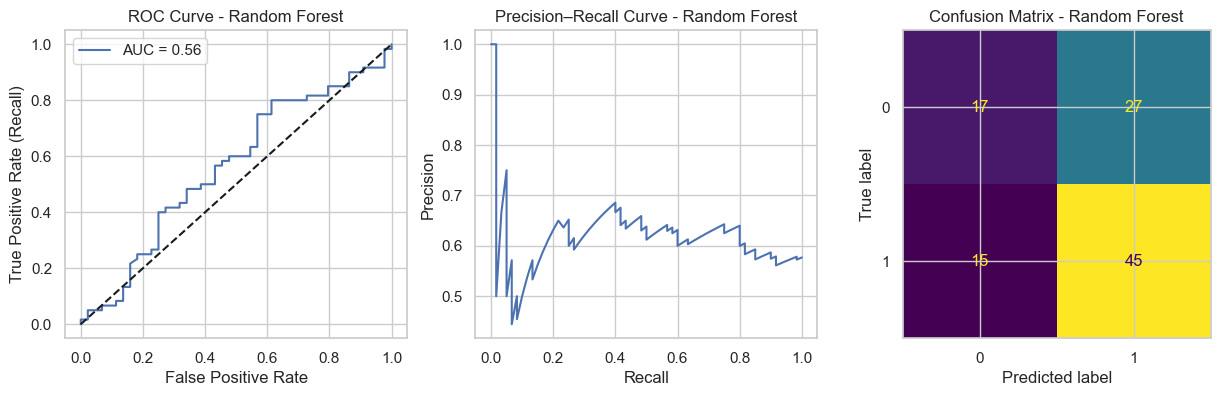

In [134]:
y_proba = forest.predict_proba(X_test_norm)[:, 1]
y_pred = (y_proba >= 0.4).astype(int)

fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(15, 4))

    # ROC
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title(f'ROC Curve - Random Forest')
plt.legend()

    # --- Precision–Recall Curve ---
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.subplot(1, 3, 2)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision–Recall Curve - Random Forest')

    # --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.subplot(1, 3, 3)
ConfusionMatrixDisplay(cm).plot(ax=plt.gca(), colorbar=False)
plt.title(f'Confusion Matrix - Random Forest')
plt.show()

In [57]:
with open("../models/Ensemble/ada_bag_logreg.pk1", "wb") as file:
    pickle.dump(ada_bag_reg, file)

In [73]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(logreg, random_state=0).fit(X_test, y_test)

# Show feature importances
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.0115 ± 0.0353,DC
0 ± 0.0000,FFMC_log
0 ± 0.0000,rain_log
0 ± 0.0000,ISI_log
0 ± 0.0000,wind
0 ± 0.0000,RH
0 ± 0.0000,temp
-0.0385 ± 0.0211,DMC


In [84]:
perm = PermutationImportance(bagging_reg, random_state=0).fit(X_test, y_test)

# Show feature importances
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.0019 ± 0.0077,DC
0 ± 0.0000,FFMC_log
0 ± 0.0000,ISI_log
0 ± 0.0000,rain_log
0 ± 0.0000,wind
0 ± 0.0000,RH
0 ± 0.0000,temp
0 ± 0.0000,DMC


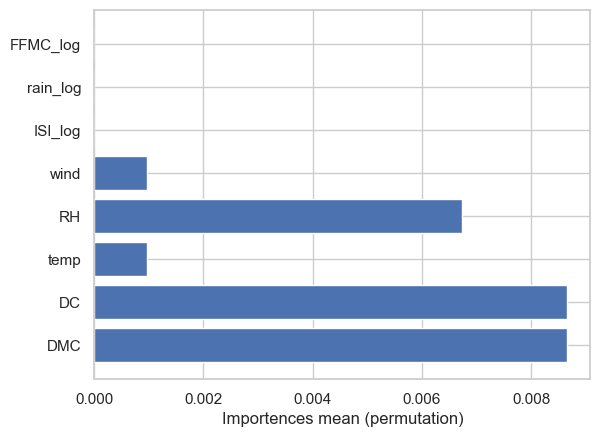

In [88]:
from sklearn.inspection import permutation_importance

result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=42)
importances = result.importances_mean

# Affichage
import matplotlib.pyplot as plt
plt.barh(X_test.columns, importances)
plt.xlabel("Importences mean (permutation)")
plt.show()

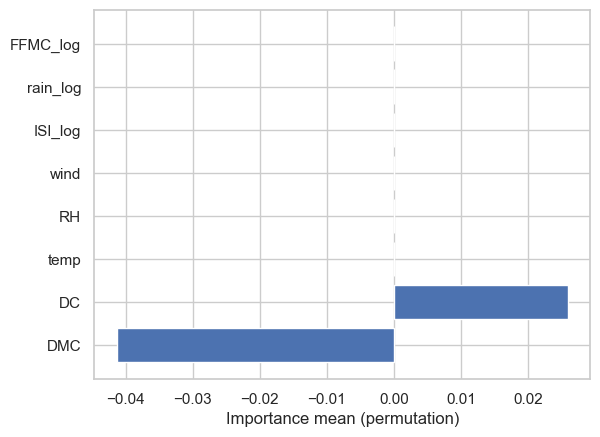

In [87]:
result = permutation_importance(logreg, X_test, y_test, n_repeats=10, random_state=42)
importances = result.importances_mean

# Affichage
import matplotlib.pyplot as plt
plt.barh(X_test.columns, importances)
plt.xlabel("Importance mean (permutation)")
plt.show()

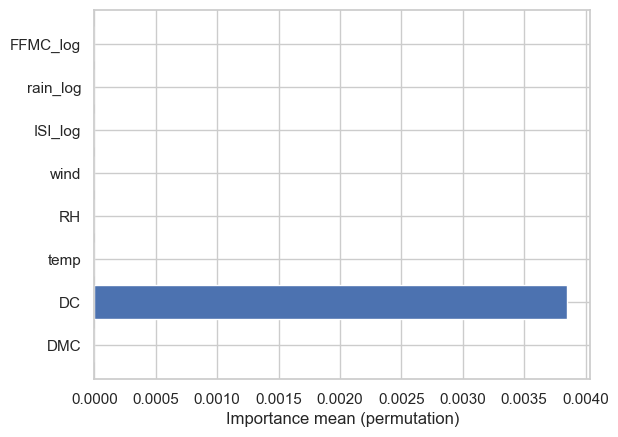

In [89]:
result = permutation_importance(bagging_reg, X_test, y_test, n_repeats=10, random_state=42)
importances = result.importances_mean

# Affichage
import matplotlib.pyplot as plt
plt.barh(X_test.columns, importances)
plt.xlabel("Importance mean (permutation)")
plt.show()

In [59]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import optuna
import optuna.visualization as vis
import time
import scipy.stats as st

parameter_grid = {"max_samples": [4, 16],
                  "random_state": [0, 100],
                  "max_features": [1, 5]} # In example we're going to test 2 * 2 * 2 * 2 = 16 combinations of hyperparameters


# We need to set this two variables to be able to compute a confidence interval
confidence_level = 0.95
folds = 10

# Now we need to create an intance of the GridSearchCV class
gs = GridSearchCV(bagging_reg, param_grid=parameter_grid, cv=folds, verbose=10) # Here the "cv" allows you to define the number of folds to use.

start_time = time.time()
gs.fit(X_train_norm, y_train)
end_time = time.time()

print("\n")
print(f"Time taken to find the best combination of hyperparameters among the given ones: {end_time - start_time: .4f} seconds")
print("\n")

#display(results_df)

# Let's store the best model
best_model = gs.best_estimator_

# Now is time evaluate the model in the test set
y_pred_test_df = best_model.predict(X_test_norm)
y_pred_test_df = best_model.predict(X_test_norm)

y_pred_test_df = best_model.predict(X_test_norm)

print(f"The accuracy of the model is {best_model.score(X_test_norm, y_pred_test_df) *100: .2f}%")
print(f"The Recall for True fires is {recall_score(y_test, y_pred_test_df,average = "binary") *100: .2f}%")
print(f"The F1 is {f1_score(y_test, y_pred_test_df,average = "binary") *100: .2f}%")
print(f"The Precision is {precision_score(y_test, y_pred_test_df,average = "binary") *100: .2f}%")

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10; 1/8] START max_features=1, max_samples=4, random_state=0..............
[CV 1/10; 1/8] END max_features=1, max_samples=4, random_state=0;, score=0.500 total time=   3.0s
[CV 2/10; 1/8] START max_features=1, max_samples=4, random_state=0..............
[CV 2/10; 1/8] END max_features=1, max_samples=4, random_state=0;, score=0.500 total time=   2.6s
[CV 3/10; 1/8] START max_features=1, max_samples=4, random_state=0..............
[CV 3/10; 1/8] END max_features=1, max_samples=4, random_state=0;, score=0.500 total time=   2.8s
[CV 4/10; 1/8] START max_features=1, max_samples=4, random_state=0..............
[CV 4/10; 1/8] END max_features=1, max_samples=4, random_state=0;, score=0.512 total time=   2.7s
[CV 5/10; 1/8] START max_features=1, max_samples=4, random_state=0..............
[CV 5/10; 1/8] END max_features=1, max_samples=4, random_state=0;, score=0.512 total time=   2.7s
[CV 6/10; 1/8] START max_features=1, max_sam

In [61]:
print(f"{best_model}")

BaggingClassifier(estimator=LogisticRegression(), max_features=5, max_samples=4,
                  n_estimators=100, random_state=100)
